# HW3

In the .csv file, we have some mock galaxys' information along the radius
- `R`: in the unit of arcsec, in the header of file it is written as Reff
- `mu`: in the unit of mag/arcsec^2, the surface brightness in a given R
- `mu`: the error of `mu`
- All these galaxies are in `D=200Mpc` away from us.

## **Todo**

1. Use Sersic profile to fit the point, show the `I0`, `Reff`, `n_index`
2. Determine the total luminosity of galaxy in terms of solar luminosity in r-band
3. What is the modulus distance

# Solution

## Q1

Sersic formular

$$I(R)=I_0exp[-\beta_n(\frac{R}{R_e})^{1/n}]=I_e exp[-\beta_n\{(\frac{R}{R_e})^{1/n}-1\}]$$

where $\beta_n=2n-0.324$, **n is decimal is ok**

Write in log:

$$\mu(R)=\mu_e+1.086\beta_n[(\frac{R}{R_e})^{1/n}-1]$$

where $\mu_e=-2.5log_{10}Ie$, $-2.5log_{10}e\approx1.086$

We can use `scipy.optimize.curve_fit` to fit the data. For more detail about this formular, [click here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). I write two func to solve the fit. One is `get_sersic_params` in which the Sersic index can be decimal. The other is `get_sersic_params_when_sersic_is_int`. 
- `curve_fit` use non-linear least squares to fit
  - If we don't consider the mu_err, the you should write something like `curve_fit(R,mu)` to get the fit. In this case the optimized function is $\chi^2=\sum((y_{real}-y_{fit})^2)$
  - But we have the mu_err, so you'd better write someting like `curve_fit(R,mu,sigma=mu_err)` to get the fit. In this case the optimized function is $\chi^2=\sum(((y_{real}-y_{fit})/(sigma))^2)$. 


## Q2

You need to use this formular to convert the `\mu_0` to `I_0`:
$$\mu_0-M_\odot-5log(D/10pc)=-2.5log(\frac{I_0}{L_{\odot}/arcsec^2})\tag{1}$$

Or you can use this one from the book *galaxy formation and evolution* Formular(2.8)
$$\mu_0=-2.5log(\frac{I_0}{L_\odot pc^{-2}})+21.572+M_\odot\tag{2}$$

It can be proved that (1) & (2) are exactly the same. I will show you in the appendix.

From the step above, we get the `I0` in the unit of $L_\odot/arcsec^2$ or $L_\odot/pc^2$. Then we can integrate the surface brightness (or the intensity) to get the total luminosity. Assuming spherically symmetric, the luminosity of sersic profile is analysable.
$$L=2\pi\int^\infty_0 I(R)RdR=\frac{2\pi n \Gamma(2n)}{\beta_n^{2n}} I_0 R^2_e$$

where $\Gamma(n)=n-1!$, $I_0=I_eexp(\beta_n)$

For (1), I write a func `get_lumi_from_I0_pc2`. For (2), I write a func `get_lumi_from_I0_arcsec2`. Because the result are the same I just show one of them.

## Q3 
This question is easy. Just remember the definition of **distance modulus = 5log(D/10pc)= apparant mag - Abs mag**


## The result
- When the Sersic index is int. 
  - Consider the mu_err when doing the fitting.
    - <font color=red>plot the geometric approach</font>
    - The best fit Sersic parameters
    - The distance modulus
    - The total luminosity of the galaxy, and Absolute magnitude
  - Ignore the mu_err when doing the fitting.
- When the Sersic index is decimal
  - Consider the mu_err when doing the fitting.
      - The best fit Sersic parameters
      - The distance modulus
      - The total luminosity of the galaxy, and Absolute magnitude
  - Ignore the mu_err when doing the fitting.

# The code

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [59]:
def mu_R_func(R,Re,mu_e,n_sersic):
    beta_n=2*n_sersic-0.324
    # -2.5log10(e)\approx 1.086
    mu_R=mu_e+1.086*beta_n*((R/Re)**(1/n_sersic)-1)
    return mu_R

def get_sersic_params(loc_ls,consider_err=True,output=True,output_plot=False,*args,**kwargs):
    result=pd.DataFrame(columns=['Re','mu_e','n_sersic','mu_0'])
    for i in range(len(loc_ls)):
        data=pd.read_csv(loc_ls[i])
        if consider_err==True:
            popt, pcov=curve_fit(mu_R_func,data.Reff.values,data.mu.values,sigma=data.mu_err)
        else: 
            popt, pcov=curve_fit(mu_R_func,data.Reff.values,data.mu.values)

        result.loc[i,['Re','mu_e','n_sersic']]=popt
        # mu_0=mu_e-1.086*beta_n
        mu_0=popt[1]-(1.086*2*popt[2]-0.324)
        mu_fit=mu_R_func(data.Reff.values,popt[0],popt[1],popt[2])
        result.loc[i,'mu_0']=mu_0
        if output == True:
            if consider_err==True:
                Chi2=sum(((mu_fit-data.mu.values)/(data.mu_err.values))**2)
                print('{}:   Re: {:.3f}, mu_e: {:.3f}, n_sersic: {:.3f}, mu_0: {:.3f}, Chi2: {:.3f}'.format(loc_ls[i],popt[0],popt[1],popt[2],mu_0,Chi2))
            else:
                Chi2=sum((mu_fit-data.mu.values)**2)
                print('{}:   Re: {:.3f}, mu_e: {:.3f}, n_sersic: {:.3f}, mu_0: {:.3f}, Chi2: {:.3f}'.format(loc_ls[i],popt[0],popt[1],popt[2],mu_0,Chi2))
        if output_plot == True:
            R=np.linspace(0,max(data.Reff.max(),20))
            mu=mu_R_func(R,popt[0],popt[1],popt[2])
            plt.figure(figsize=(24,6))

            ax=plt.subplot(131)
            plt.errorbar(data.Reff.values,data.mu.values,data.mu_err.values)
            plt.plot(R,mu,label='Re = {:.2f}\n\nmu_e = {:.2f}\n\nn = {:.2f}'.format(popt[0],popt[1],popt[2]))
            plt.legend(loc='upper right')
            plt.xlabel('R/arcsec')
            plt.ylabel('$\mu(R)$/(mag/arcsec^2)')
            ax.invert_yaxis()
            plt.title(loc_ls[i])

            
            ax=plt.subplot(132)
            plt.plot(data.Reff.values,data.mu.values,'^',label='data_original')
            plt.plot(data.Reff.values,mu_fit,'*',label='data_fit')
            plt.legend(loc='upper right')
            plt.xlabel('R/arcsec')
            plt.ylabel('$\mu(R)$/(mag/arcsec^2)')
            ax.invert_yaxis()
            plt.title(loc_ls[i])

            n_sersic_round=round(popt[2])
            ax=plt.subplot(133)
            plt.plot(data.Reff.values**(1/n_sersic_round),data.mu.values,'^',label='data_original')
            plt.plot(data.Reff.values**(1/n_sersic_round),mu_fit,'*',label='data_fit')
            plt.legend(loc='upper right')
            plt.xlabel('R'+'$^{1/'+str(n_sersic_round)+'}$'+'/arcsec')
            plt.ylabel('$\mu(R)$/(mag/arcsec^2)')
            ax.invert_yaxis()
            plt.title(loc_ls[i])
            plt.show()
    return result

def get_sersic_params_when_sersic_is_int(loc_ls,sersic_is_int=False,consider_err=True,*args,**kwargs):
    result=pd.DataFrame(columns=['Re','mu_e','n_sersic','mu_0'])
    for i in range(len(loc_ls)):
        data=pd.read_csv(loc_ls[i])
        # because we know that the sersic is only in 2,3,4,5,6
        possible_ls=[2,3,4,5,6]
        Chi2_best=1E10
        print('We are focusing the file {}'.format(loc_ls[i]))
        plt.figure(figsize=(24,12))
        for j in range(len(possible_ls)):
            n=possible_ls[j]
            def mu_R_func_to_fit(R,Re,mu_e):
                n_sersic=n
                beta_n=2*n_sersic-0.324
                # -2.5log10(e)\approx 1.086
                mu_R=mu_e+1.086*beta_n*((R/Re)**(1/n_sersic)-1)
                return mu_R
            if consider_err==True:
                if j==0:
                    print('We consider the mu_err when doing the fitting.')
                popt, pcov=curve_fit(mu_R_func_to_fit,data.Reff.values,data.mu.values,sigma=data.mu_err)
                Re_fit,mu_e_fit=popt[0],popt[1]
                mu_fit=mu_R_func(data.Reff.values,Re_fit,mu_e_fit,n)
                Chi2=sum(((mu_fit-data.mu.values)/(data.mu_err.values))**2)
                print('If the n_sersic is {}, the Chi2: {:.3f} and Re: {:.3f} mu_e: {:.3f}'.format(n,Chi2,Re_fit,mu_e_fit))
            else: 
                if j==0:
                    print('We don\'t consider the mu_err when doing the fitting.')
                popt, pcov=curve_fit(mu_R_func_to_fit,data.Reff.values,data.mu.values)
                Re_fit,mu_e_fit=popt[0],popt[1]
                mu_fit=mu_R_func(data.Reff.values,Re_fit,mu_e_fit,n)
                Chi2=sum((mu_fit-data.mu.values)**2)
                print('If the n_sersic is {}, the Chi2: {:.3f} and Re: {:.3f} mu_e: {:.3f}'.format(n,Chi2,Re_fit,mu_e_fit))
            
            ax=plt.subplot(eval('2'+'3'+str(j+1)))
            plt.plot(data.Reff.values**(1/n),data.mu.values,'^',label='data_original')
            plt.plot(data.Reff.values**(1/n),mu_fit,'*',label='data_fit')
            plt.legend(loc='upper right')
            plt.xlabel('R'+'$^{1/'+str(n)+'}$'+'/arcsec')
            plt.ylabel('$\mu(R)$/(mag/arcsec^2)')
            ax.invert_yaxis()
            plt.title(loc_ls[i]+', n='+str(n)+', Chi2: {:.3f}'.format(Chi2))

            if Chi2<Chi2_best:
                Chi2_best=Chi2
                n_best,Re_best,mu_e_best=n,Re_fit,mu_e_fit
        
        ax=plt.subplot(236)
        R=np.linspace(0,max(data.Reff.max(),20))
        mu=mu_R_func(R,Re_best,mu_e_best,n_best)
        plt.errorbar(data.Reff.values,data.mu.values,data.mu_err.values)
        plt.plot(R,mu,label='Re = {:.2f}\n\nmu_e = {:.2f}\n\nn = {:.2f}'.format(Re_best,mu_e_best,n_best))
        plt.legend(loc='upper right')
        plt.xlabel('R/arcsec')
        plt.ylabel('$\mu(R)$/(mag/arcsec^2)')
        ax.invert_yaxis()
        plt.title(loc_ls[i])
        

        result.loc[i,['Re','mu_e','n_sersic']]=Re_best,mu_e_best,n_best
        # mu_0=mu_e-1.086*beta_n
        mu_0=mu_e_best-(1.086*2*n_best-0.324)
        result.loc[i,'mu_0']=mu_0
        print('So the best fit Sersic index is n={}, value of the rest of Sersic parameters are Re: {:.3f}, mu_e: {:.3f}, mu_0: {:.3f}'.format(n_best,Re_best,mu_e_best,mu_0))
        plt.show()
    return result

def get_lumi_from_I0_pc2(data,output=True):
    # The unit of I0 is L_sun/pc^2
    lumi_ls=[]
    for i in range(len(data)):
        n,I0,Re=data.n_sersic.values[i],data.I0_pc2.values[i],data.Re_pc.values[i]
        beta_n=2*n-0.324
        L=2*np.pi*n*np.math.gamma(2*n)/beta_n**(2*n)*I0*Re**2
        lumi_ls.append(L)
        if output==True:
            print('The ID: {} galaxy has luminosity {:.3E} in the unit of Lsun'.format(str(i),L))
    return lumi_ls

def get_lumi_from_I0_arcsec2(data,output=True):
    # The unit of I0 is L_sun/arcsec^2
    lumi_ls=[]
    for i in range(len(data)):
        n,I0,Re=data.n_sersic.values[i],data.I0_arcsec2.values[i],data.Re.values[i]
        beta_n=2*n-0.324
        L=2*np.pi*n*np.math.gamma(2*n)/beta_n**(2*n)*I0*Re**2
        lumi_ls.append(L)
        if output==True:
            print('The ID: {} galaxy has luminosity {:.3E} in the unit of Lsun'.format(str(i),L))
    return lumi_ls

# Sersic index is int

## Consider mu_err

We are focusing the file 0_1.csv
We consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 20.203 and Re: 17.950 mu_e: 25.539
If the n_sersic is 3, the Chi2: 502.803 and Re: 49.205 mu_e: 27.038
If the n_sersic is 4, the Chi2: 1141.923 and Re: 145.776 mu_e: 28.537
If the n_sersic is 5, the Chi2: 1655.082 and Re: 446.192 mu_e: 30.035
If the n_sersic is 6, the Chi2: 2050.033 and Re: 1388.503 mu_e: 31.533
So the best fit Sersic index is n=2, value of the rest of Sersic parameters are Re: 17.950, mu_e: 25.539, mu_0: 21.519


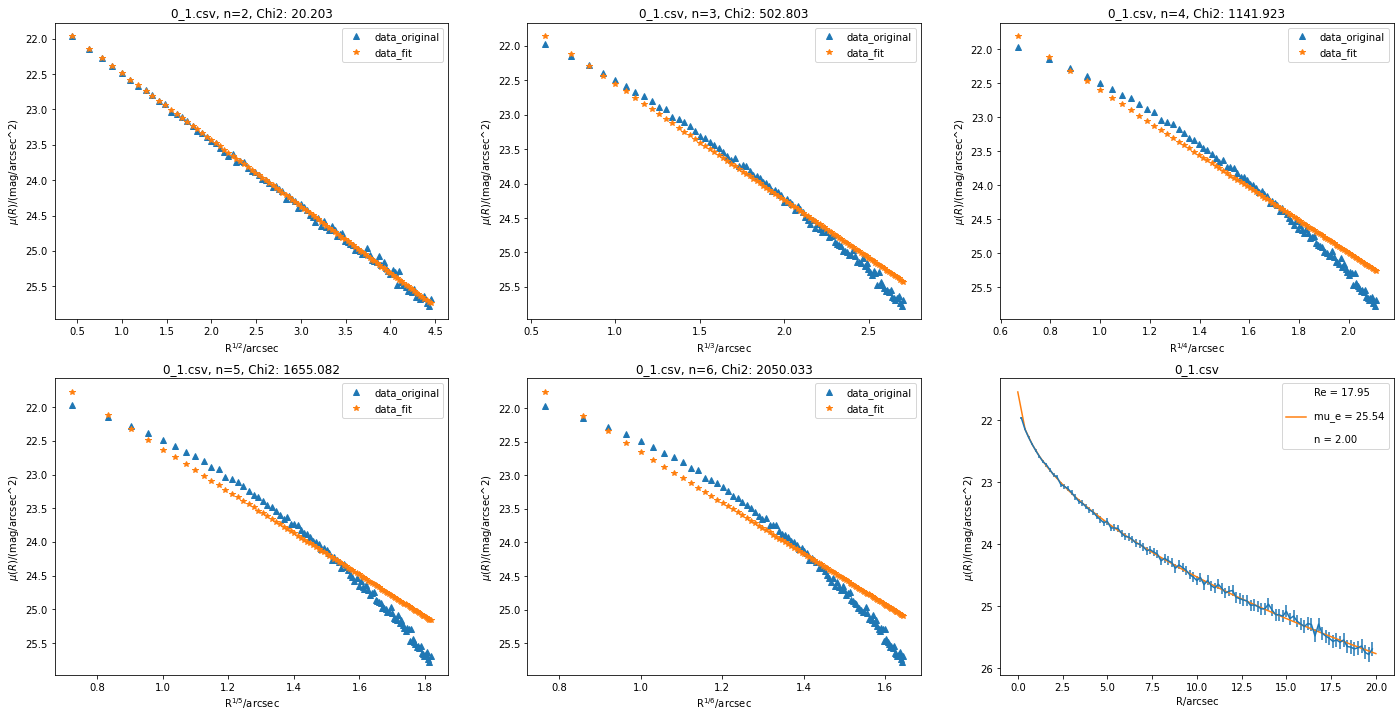

We are focusing the file 1_1.csv
We consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 1795.750 and Re: 6.836 mu_e: 23.544
If the n_sersic is 3, the Chi2: 230.249 and Re: 9.909 mu_e: 24.378
If the n_sersic is 4, the Chi2: 21.353 and Re: 15.163 mu_e: 25.210
If the n_sersic is 5, the Chi2: 93.159 and Re: 23.730 mu_e: 26.041
If the n_sersic is 6, the Chi2: 224.642 and Re: 37.564 mu_e: 26.873
So the best fit Sersic index is n=4, value of the rest of Sersic parameters are Re: 15.163, mu_e: 25.210, mu_0: 16.846


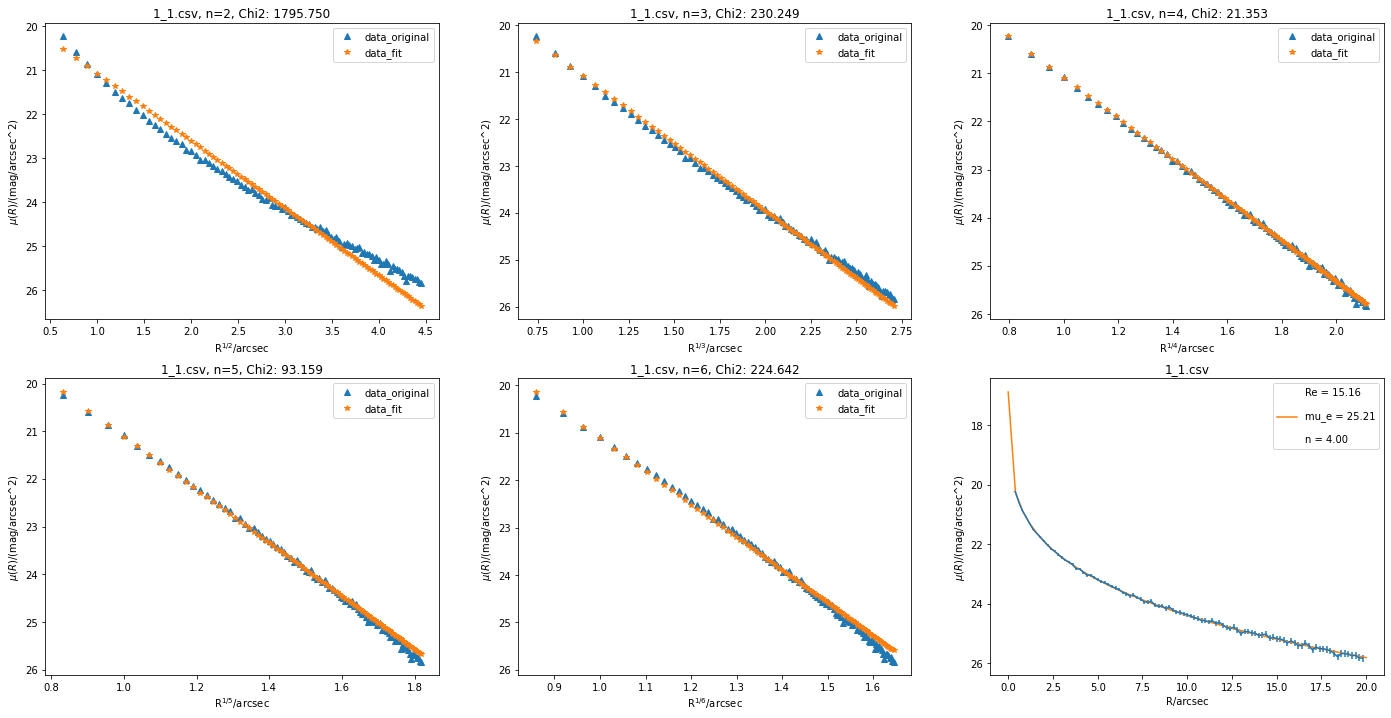

We are focusing the file 2_1.csv
We consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 4181.856 and Re: 5.124 mu_e: 23.616
If the n_sersic is 3, the Chi2: 1123.312 and Re: 6.380 mu_e: 24.232
If the n_sersic is 4, the Chi2: 308.708 and Re: 8.386 mu_e: 24.845
If the n_sersic is 5, the Chi2: 70.408 and Re: 11.275 mu_e: 25.458
If the n_sersic is 6, the Chi2: 18.884 and Re: 15.332 mu_e: 26.069
So the best fit Sersic index is n=6, value of the rest of Sersic parameters are Re: 15.332, mu_e: 26.069, mu_0: 13.361


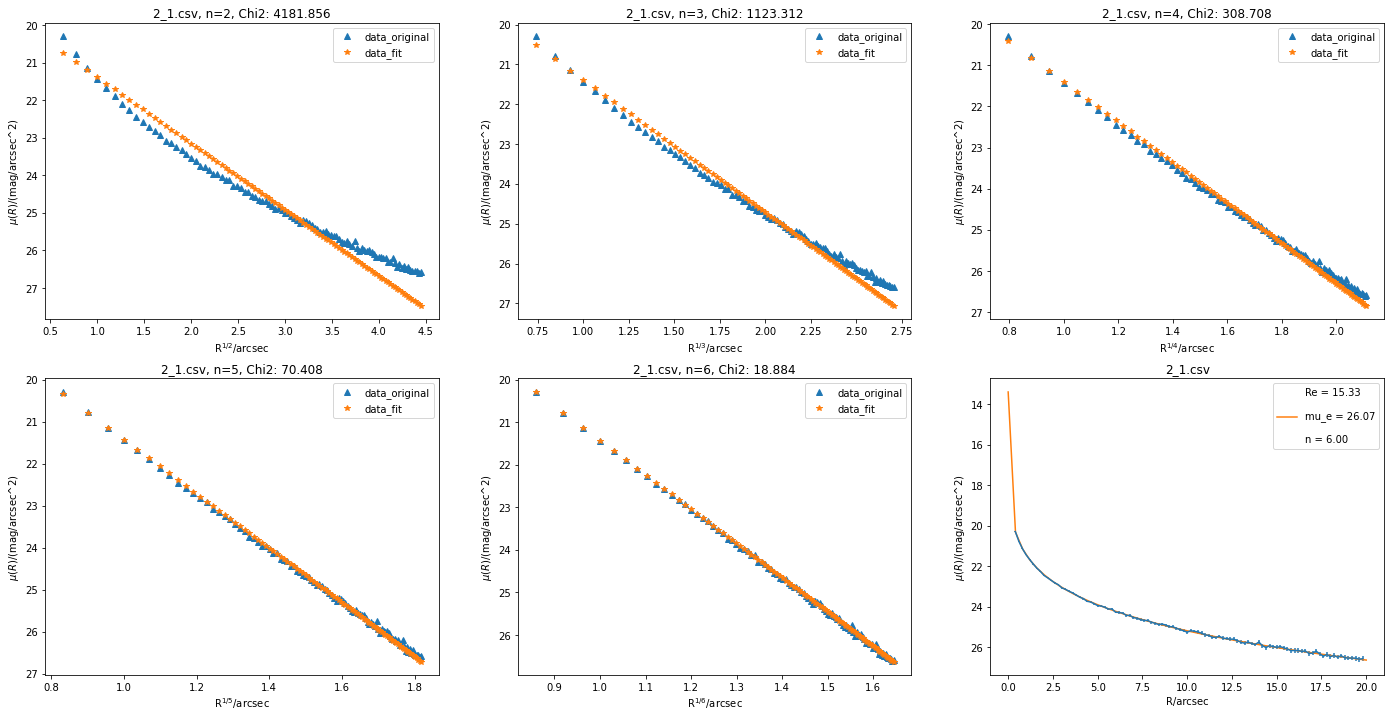

We are focusing the file 3_1.csv
We consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 23.437 and Re: 17.924 mu_e: 25.544
If the n_sersic is 3, the Chi2: 277.425 and Re: 42.911 mu_e: 26.904
If the n_sersic is 4, the Chi2: 615.775 and Re: 108.456 mu_e: 28.264
If the n_sersic is 5, the Chi2: 887.779 and Re: 280.355 mu_e: 29.624
If the n_sersic is 6, the Chi2: 1097.556 and Re: 733.021 mu_e: 30.984
So the best fit Sersic index is n=2, value of the rest of Sersic parameters are Re: 17.924, mu_e: 25.544, mu_0: 21.524


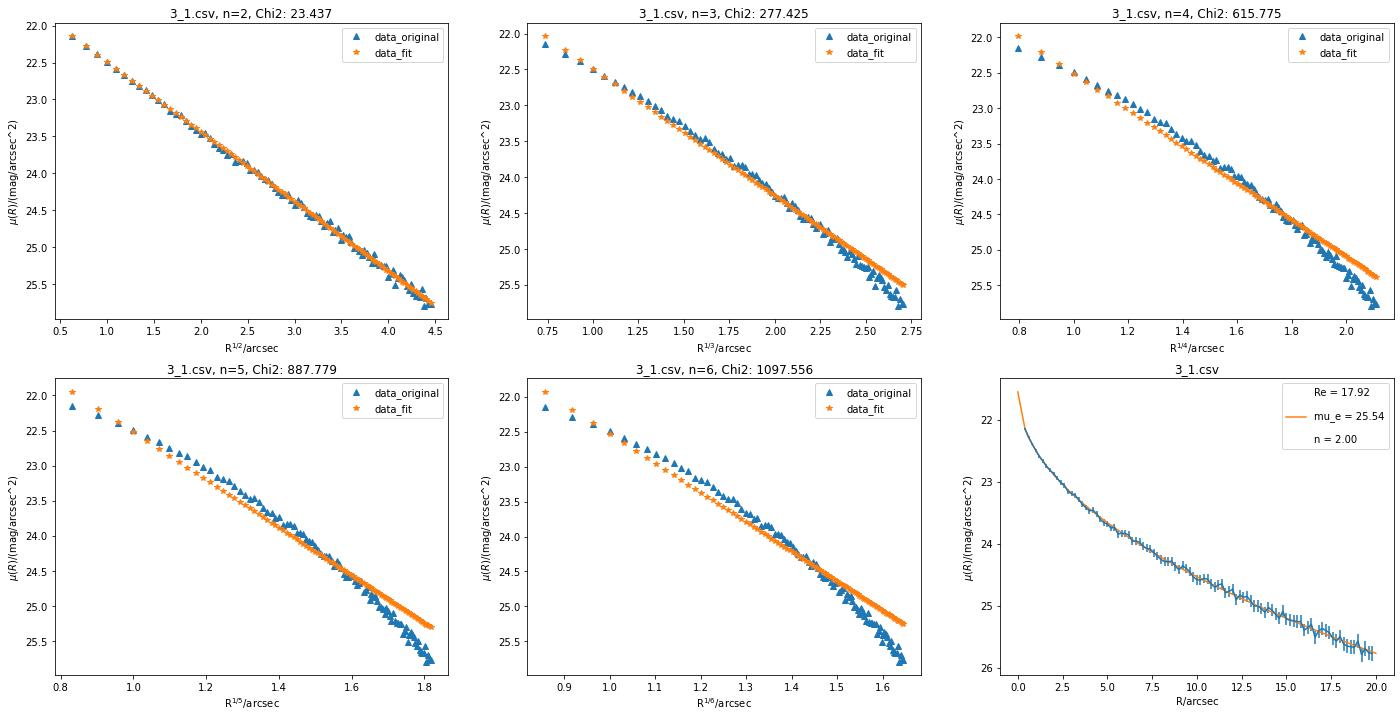

We are focusing the file 4_1.csv
We consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 3269.474 and Re: 4.883 mu_e: 24.342
If the n_sersic is 3, the Chi2: 705.915 and Re: 5.963 mu_e: 24.927
If the n_sersic is 4, the Chi2: 129.700 and Re: 7.686 mu_e: 25.509
If the n_sersic is 5, the Chi2: 29.041 and Re: 10.133 mu_e: 26.090
If the n_sersic is 6, the Chi2: 66.474 and Re: 13.513 mu_e: 26.671
So the best fit Sersic index is n=5, value of the rest of Sersic parameters are Re: 10.133, mu_e: 26.090, mu_0: 15.554


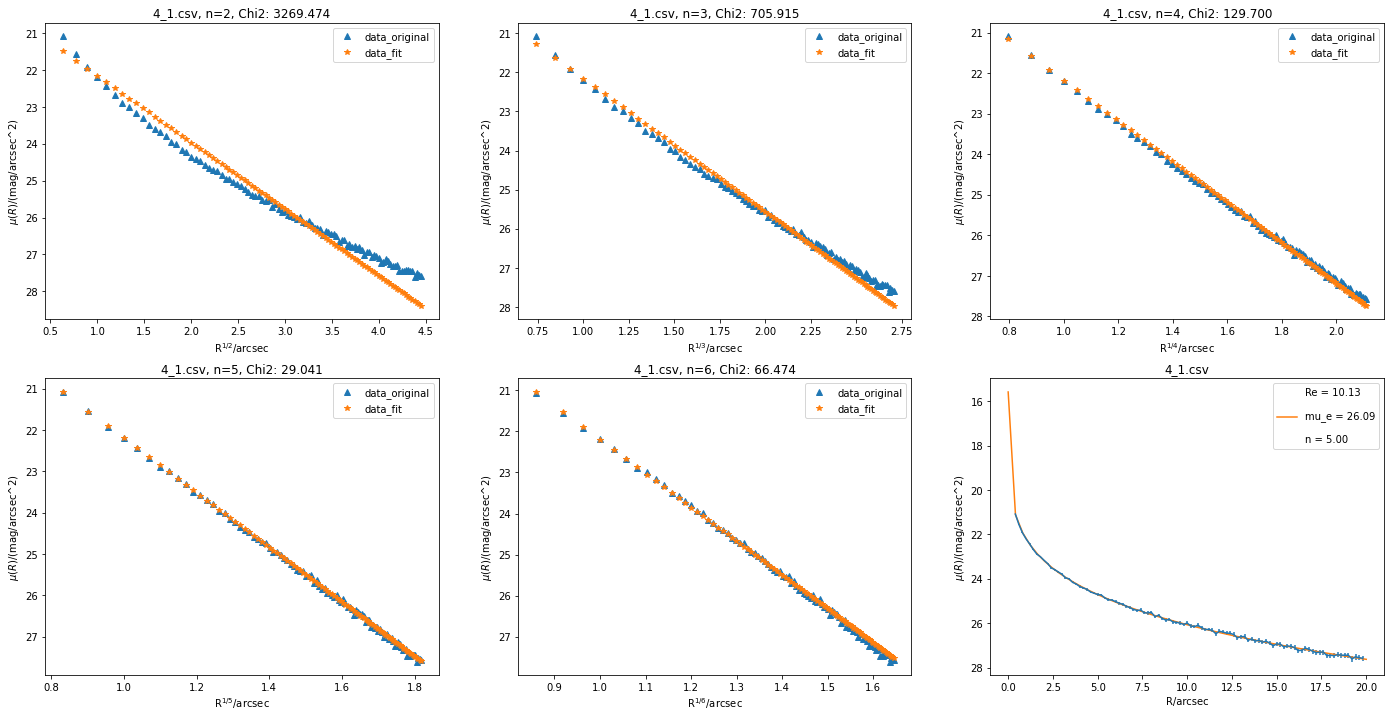

We are focusing the file 5_1.csv
We consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 516.218 and Re: 9.036 mu_e: 25.015
If the n_sersic is 3, the Chi2: 20.554 and Re: 15.162 mu_e: 26.029
If the n_sersic is 4, the Chi2: 178.530 and Re: 26.858 mu_e: 27.043
If the n_sersic is 5, the Chi2: 410.002 and Re: 48.658 mu_e: 28.057
If the n_sersic is 6, the Chi2: 621.670 and Re: 89.167 mu_e: 29.071
So the best fit Sersic index is n=3, value of the rest of Sersic parameters are Re: 15.162, mu_e: 26.029, mu_0: 19.837


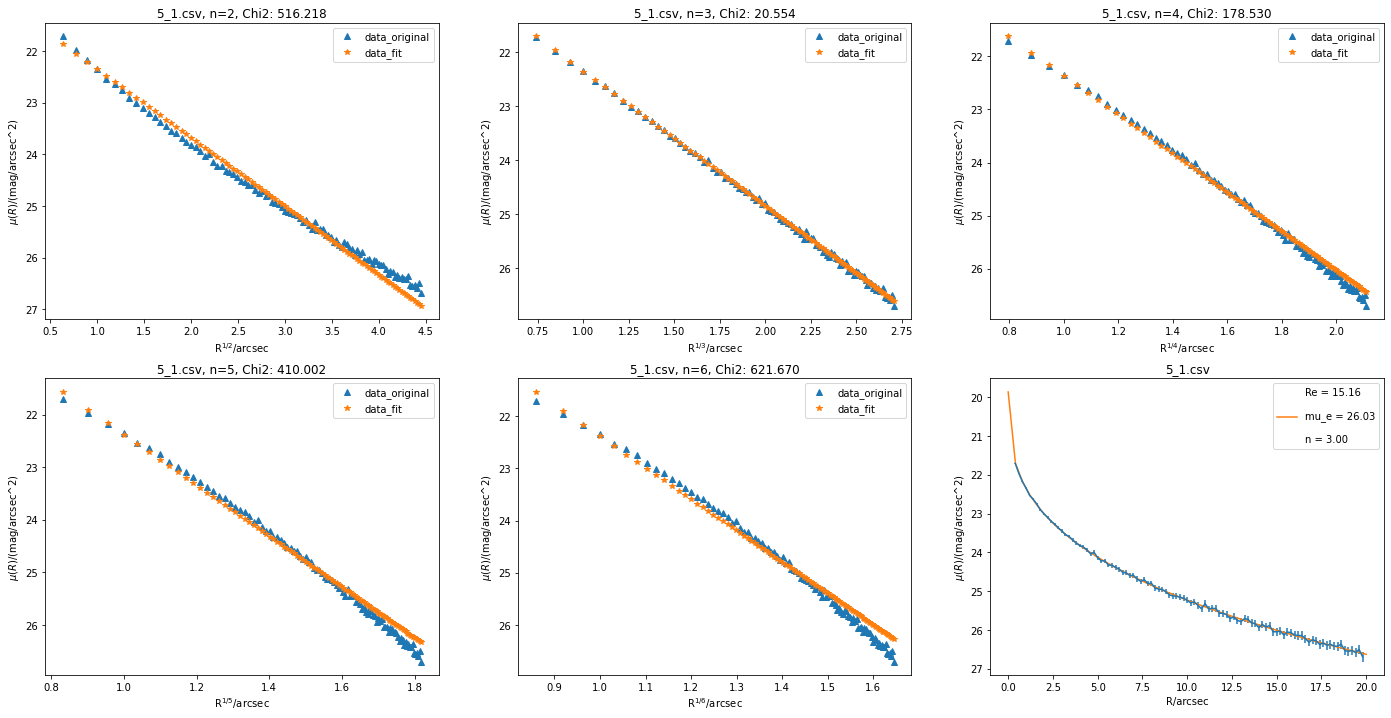

The distance modulus is 36.5051
The ID: 0 galaxy has luminosity 1.053E+10 in the unit of Lsun
The ID: 1 galaxy has luminosity 1.415E+10 in the unit of Lsun
The ID: 2 galaxy has luminosity 7.992E+09 in the unit of Lsun
The ID: 3 galaxy has luminosity 1.045E+10 in the unit of Lsun
The ID: 4 galaxy has luminosity 3.132E+09 in the unit of Lsun
The ID: 5 galaxy has luminosity 5.792E+09 in the unit of Lsun


,Re,mu_e,n_sersic,mu_0,Re_pc,I0_arcsec2,I0_pc2,Lumi,Abs_mag
0,17.9496,25.5389,2,21.5189,17404.4,7.91558e+07,84.1827,1.052931e+10,-20.296000
1,15.1627,25.2098,4,16.8458,14702.2,5.85789e+09,6229.9,1.415261e+10,-20.617091
2,15.3321,26.0693,6,13.3613,14866.5,1.45059e+11,154271,7.992030e+09,-19.996643
3,17.9236,25.5436,2,21.5236,17379.2,7.88199e+07,83.8255,1.045425e+10,-20.288232
4,10.1333,26.09,5,15.554,9825.48,1.92506e+10,20473.1,3.132172e+09,-18.979614
5,15.1618,26.0293,3,19.8373,14701.3,3.72523e+08,396.18,5.792077e+09,-19.647086


In [70]:
loc_ls=[str(i)+'_1.csv' for i in range(0,6)]
result=get_sersic_params_when_sersic_is_int(loc_ls,sersic_is_int=True,consider_err=True)
D=2e8 # pc
dist_modulus=5*np.log10(D/10)
print('The distance modulus is {:.4f}'.format(dist_modulus))
result['Re_pc']=result.Re.values*D*(2*np.pi/(360*60*60))

M_sun_r=4.76
result['I0_arcsec2']=10**((result.mu_0.values-M_sun_r-dist_modulus)/(-2.5))
result['I0_pc2']=10**((result.mu_0.values-M_sun_r-21.572)/(-2.5))
lumi_ls=get_lumi_from_I0_pc2(result)
result['Lumi']=lumi_ls
result['Abs_mag']=-2.5*np.log10(lumi_ls)+M_sun_r
display(result)

## Ignore mu_err

We are focusing the file 0_1.csv
We don't consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 0.140 and Re: 18.017 mu_e: 25.543
If the n_sersic is 3, the Chi2: 0.758 and Re: 34.362 mu_e: 26.656
If the n_sersic is 4, the Chi2: 1.617 and Re: 68.928 mu_e: 27.791
If the n_sersic is 5, the Chi2: 2.341 and Re: 141.537 mu_e: 28.935
If the n_sersic is 6, the Chi2: 2.919 and Re: 294.330 mu_e: 30.084
So the best fit Sersic index is n=2, value of the rest of Sersic parameters are Re: 18.017, mu_e: 25.543, mu_0: 21.523


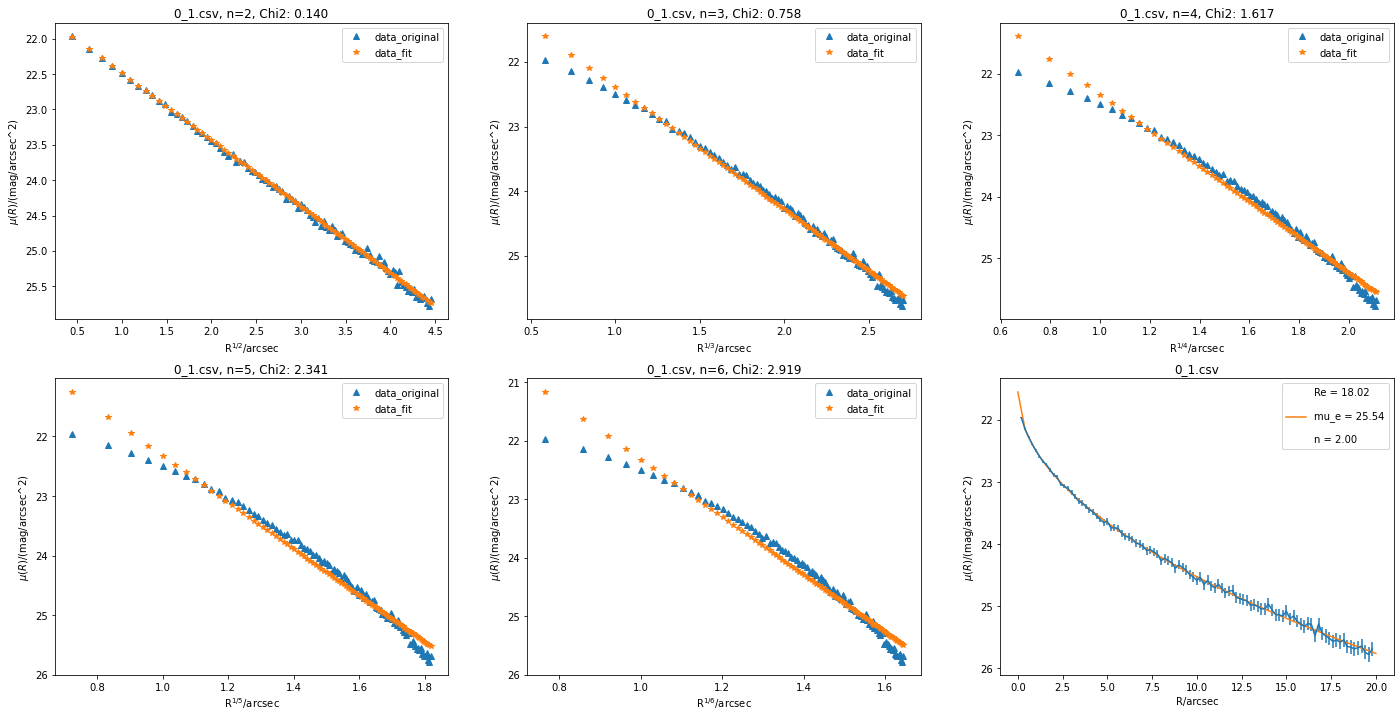

We are focusing the file 1_1.csv
We don't consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 2.206 and Re: 8.997 mu_e: 24.064
If the n_sersic is 3, the Chi2: 0.356 and Re: 11.422 mu_e: 24.620
If the n_sersic is 4, the Chi2: 0.137 and Re: 15.072 mu_e: 25.199
If the n_sersic is 5, the Chi2: 0.276 and Re: 20.236 mu_e: 25.788
If the n_sersic is 6, the Chi2: 0.491 and Re: 27.418 mu_e: 26.380
So the best fit Sersic index is n=4, value of the rest of Sersic parameters are Re: 15.072, mu_e: 25.199, mu_0: 16.835


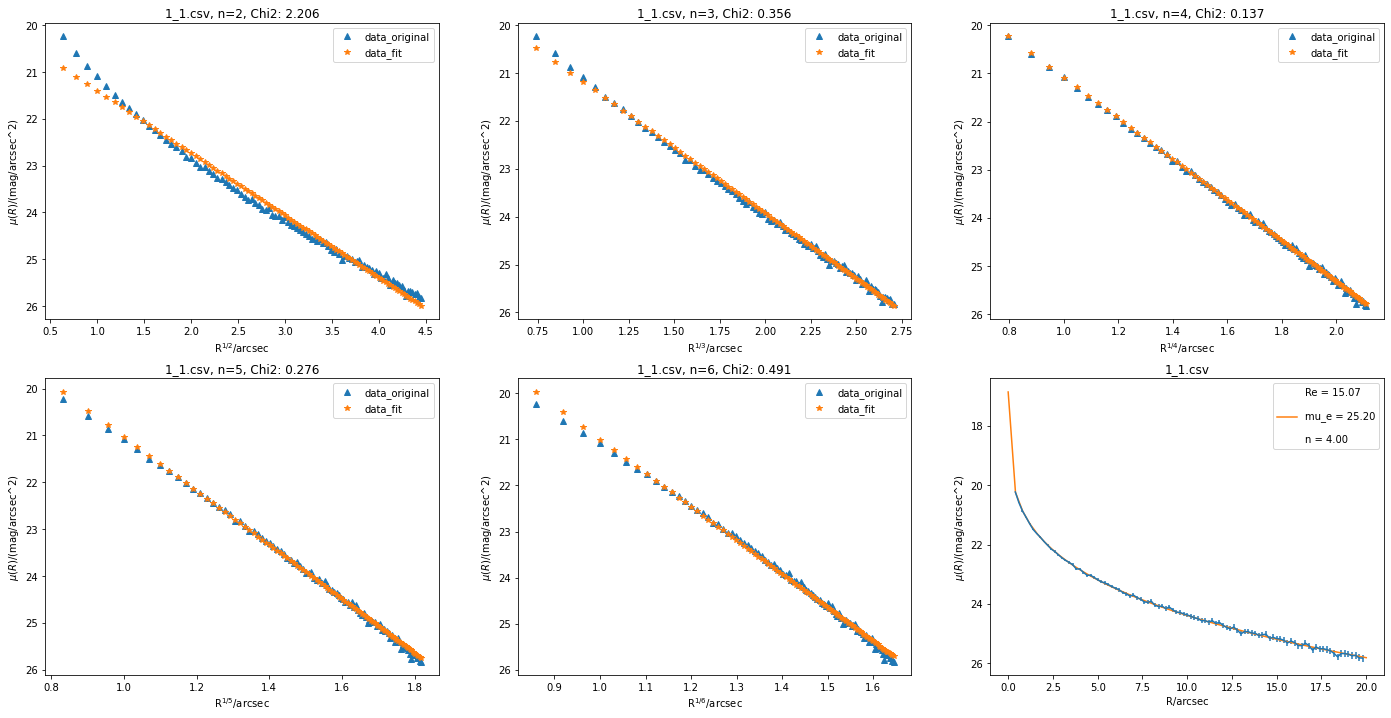

We are focusing the file 2_1.csv
We don't consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 5.190 and Re: 7.544 mu_e: 24.438
If the n_sersic is 3, the Chi2: 1.538 and Re: 8.681 mu_e: 24.825
If the n_sersic is 4, the Chi2: 0.501 and Re: 10.379 mu_e: 25.237
If the n_sersic is 5, the Chi2: 0.188 and Re: 12.623 mu_e: 25.660
If the n_sersic is 6, the Chi2: 0.122 and Re: 15.492 mu_e: 26.088
So the best fit Sersic index is n=6, value of the rest of Sersic parameters are Re: 15.492, mu_e: 26.088, mu_0: 13.380


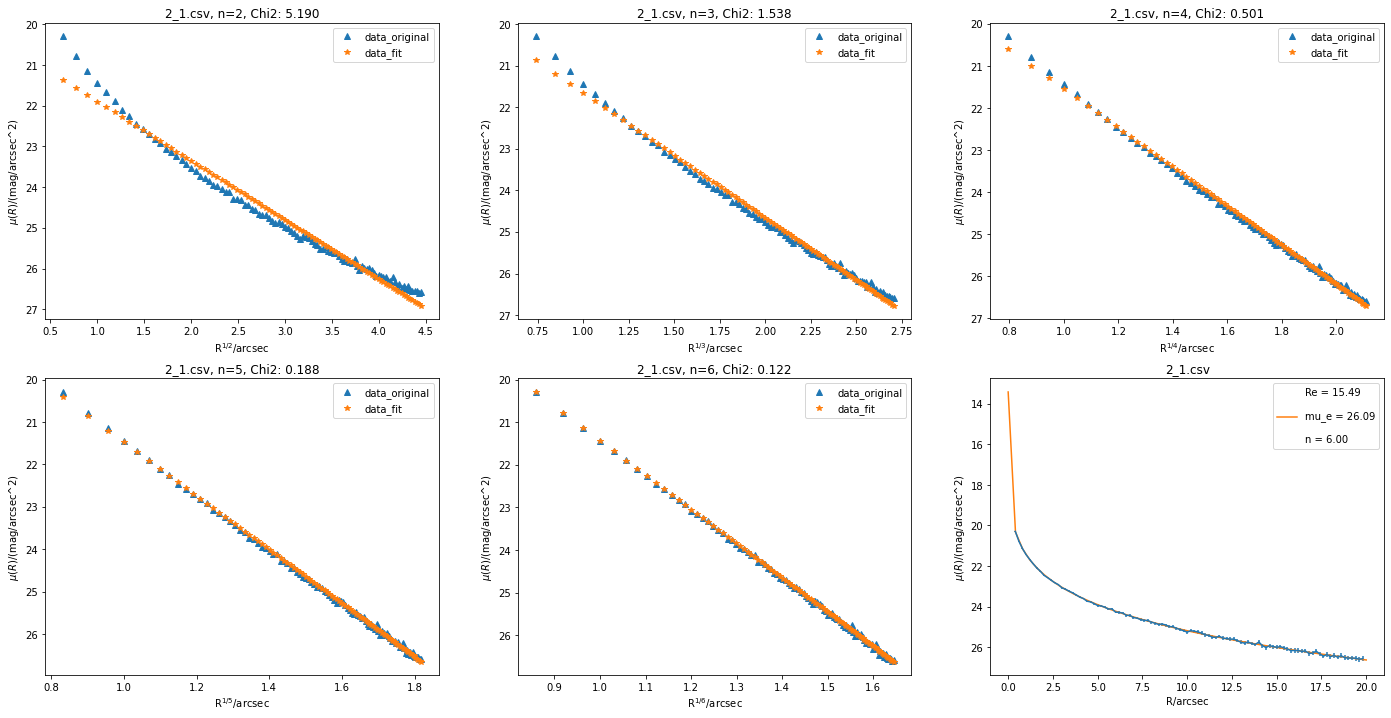

We are focusing the file 3_1.csv
We don't consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 0.160 and Re: 17.961 mu_e: 25.546
If the n_sersic is 3, the Chi2: 0.652 and Re: 33.001 mu_e: 26.606
If the n_sersic is 4, the Chi2: 1.296 and Re: 63.098 mu_e: 27.682
If the n_sersic is 5, the Chi2: 1.828 and Re: 122.803 mu_e: 28.763
If the n_sersic is 6, the Chi2: 2.247 and Re: 241.260 mu_e: 29.847
So the best fit Sersic index is n=2, value of the rest of Sersic parameters are Re: 17.961, mu_e: 25.546, mu_0: 21.526


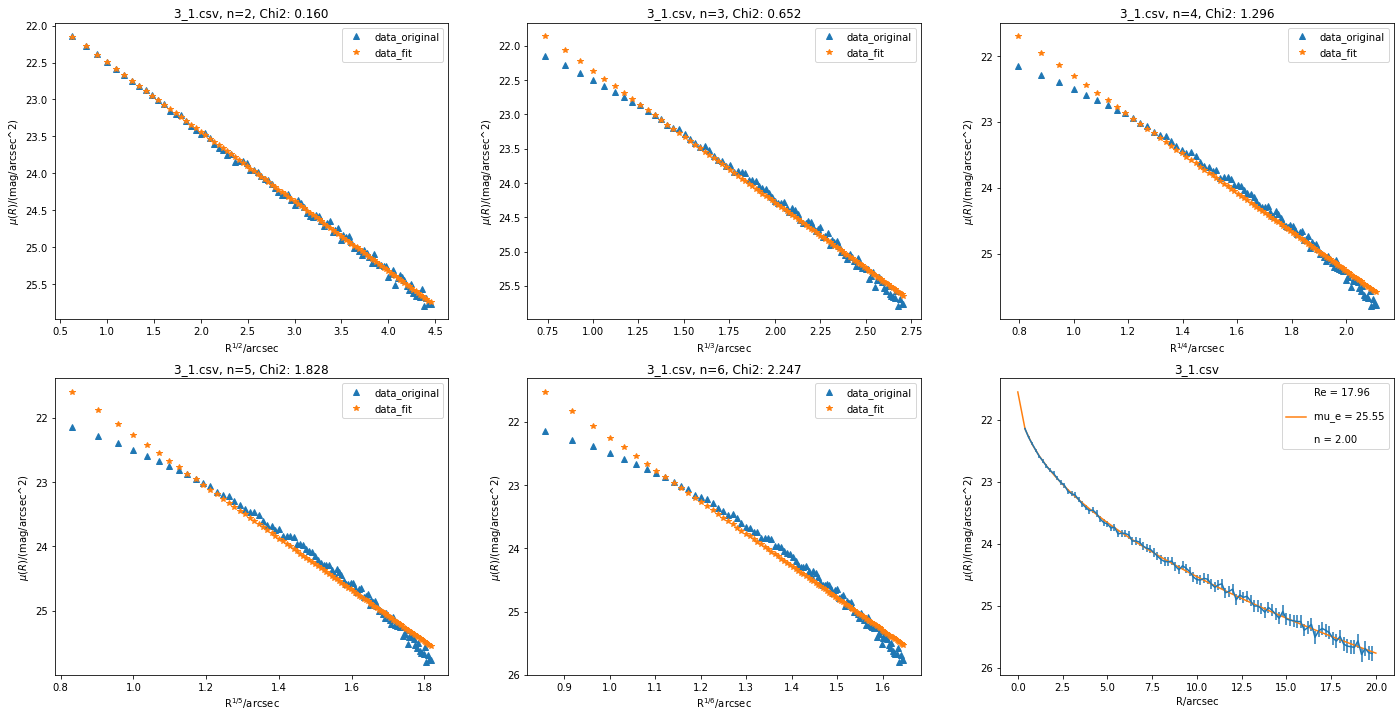

We are focusing the file 4_1.csv
We don't consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 4.410 and Re: 6.866 mu_e: 25.092
If the n_sersic is 3, the Chi2: 1.074 and Re: 7.571 mu_e: 25.402
If the n_sersic is 4, the Chi2: 0.299 and Re: 8.674 mu_e: 25.738
If the n_sersic is 5, the Chi2: 0.181 and Re: 10.111 mu_e: 26.085
If the n_sersic is 6, the Chi2: 0.260 and Re: 11.894 mu_e: 26.438
So the best fit Sersic index is n=5, value of the rest of Sersic parameters are Re: 10.111, mu_e: 26.085, mu_0: 15.549


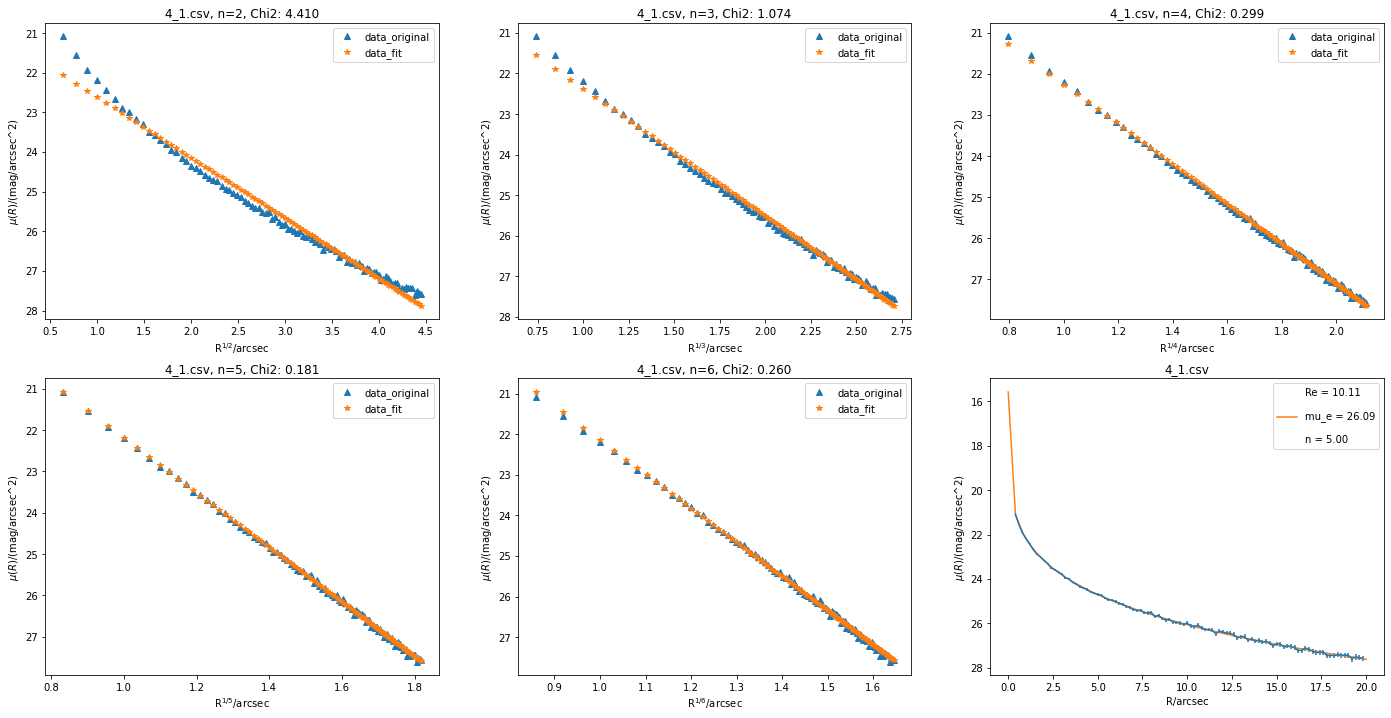

We are focusing the file 5_1.csv
We don't consider the mu_err when doing the fitting.
If the n_sersic is 2, the Chi2: 0.927 and Re: 10.774 mu_e: 25.313
If the n_sersic is 3, the Chi2: 0.134 and Re: 15.082 mu_e: 26.022
If the n_sersic is 4, the Chi2: 0.363 and Re: 21.954 mu_e: 26.751
If the n_sersic is 5, the Chi2: 0.735 and Re: 32.523 mu_e: 27.488
If the n_sersic is 6, the Chi2: 1.089 and Re: 48.626 mu_e: 28.229
So the best fit Sersic index is n=3, value of the rest of Sersic parameters are Re: 15.082, mu_e: 26.022, mu_0: 19.830


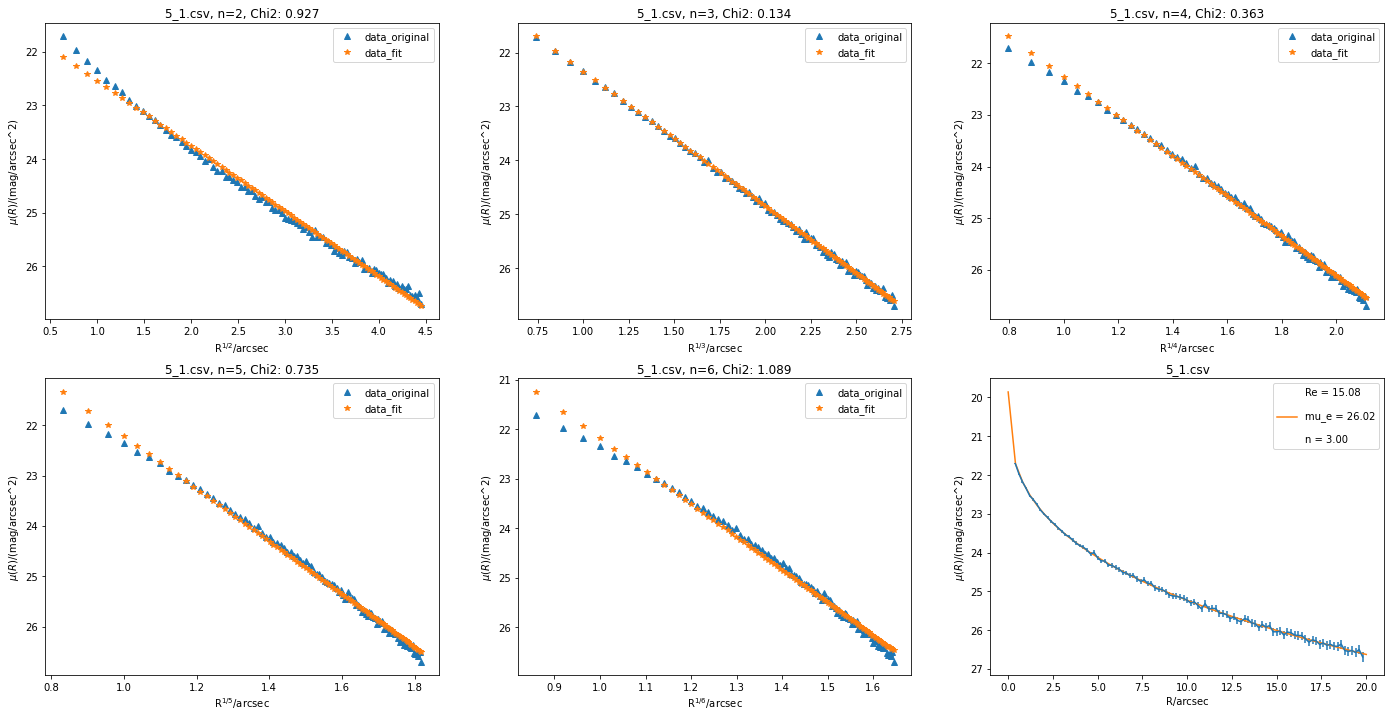

The distance modulus is 36.5051
The ID: 0 galaxy has luminosity 1.056E+10 in the unit of Lsun
The ID: 1 galaxy has luminosity 1.412E+10 in the unit of Lsun
The ID: 2 galaxy has luminosity 8.024E+09 in the unit of Lsun
The ID: 3 galaxy has luminosity 1.048E+10 in the unit of Lsun
The ID: 4 galaxy has luminosity 3.132E+09 in the unit of Lsun
The ID: 5 galaxy has luminosity 5.772E+09 in the unit of Lsun


,Re,mu_e,n_sersic,mu_0,Re_pc,I0_arcsec2,I0_pc2,Lumi,Abs_mag
0,18.0169,25.5434,2,21.5234,17469.7,7.88304e+07,83.8367,1.056486e+10,-20.299659
1,15.0724,25.1993,4,16.8353,14614.6,5.91476e+09,6290.39,1.412023e+10,-20.614604
2,15.4924,26.0875,6,13.3795,15021.9,1.42646e+11,151705,8.024274e+09,-20.001014
3,17.9608,25.5459,2,21.5259,17415.3,7.86502e+07,83.6449,1.047512e+10,-20.290397
4,10.1111,26.0854,5,15.5494,9803.98,1.93333e+10,20561,3.131874e+09,-18.979511
5,15.0817,26.0215,3,19.8295,14623.6,3.75188e+08,399.015,5.772025e+09,-19.643320


In [71]:
loc_ls=[str(i)+'_1.csv' for i in range(0,6)]
result=get_sersic_params_when_sersic_is_int(loc_ls,sersic_is_int=True,consider_err=False)
D=2e8 # pc
dist_modulus=5*np.log10(D/10)
print('The distance modulus is {:.4f}'.format(dist_modulus))
result['Re_pc']=result.Re.values*D*(2*np.pi/(360*60*60))

M_sun_r=4.76
result['I0_arcsec2']=10**((result.mu_0.values-M_sun_r-dist_modulus)/(-2.5))
result['I0_pc2']=10**((result.mu_0.values-M_sun_r-21.572)/(-2.5))
lumi_ls=get_lumi_from_I0_pc2(result)
result['Lumi']=lumi_ls
result['Abs_mag']=-2.5*np.log10(lumi_ls)+M_sun_r
display(result)

# Sersic index is decimal

## Consider mu_err

In [72]:
loc_ls=[str(i)+'_1.csv' for i in range(0,6)]
result=get_sersic_params(loc_ls,sersic_is_int=True,consider_err=True)
D=2e8 # pc
dist_modulus=5*np.log10(D/10)
print('The distance modulus is {:.4f}'.format(dist_modulus))
result['Re_pc']=result.Re.values*D*(2*np.pi/(360*60*60))

M_sun_r=4.76
result['I0_arcsec2']=10**((result.mu_0.values-M_sun_r-dist_modulus)/(-2.5))
result['I0_pc2']=10**((result.mu_0.values-M_sun_r-21.572)/(-2.5))
lumi_ls=get_lumi_from_I0_pc2(result)
result['Lumi']=lumi_ls
result['Abs_mag']=-2.5*np.log10(lumi_ls)+M_sun_r
display(result)

0_1.csv:   Re: 18.175, mu_e: 25.559, n_sersic: 2.013, mu_0: 21.510, Chi2: 20.016
1_1.csv:   Re: 15.271, mu_e: 25.223, n_sersic: 4.016, mu_0: 16.824, Chi2: 21.323
2_1.csv:   Re: 15.896, mu_e: 26.140, n_sersic: 6.116, mu_0: 13.180, Chi2: 18.495
3_1.csv:   Re: 18.224, mu_e: 25.571, n_sersic: 2.020, mu_0: 21.507, Chi2: 23.204
4_1.csv:   Re: 10.266, mu_e: 26.117, n_sersic: 5.046, mu_0: 15.481, Chi2: 28.917
5_1.csv:   Re: 14.773, mu_e: 25.981, n_sersic: 2.953, mu_0: 19.892, Chi2: 19.992
The distance modulus is 36.5051
The ID: 0 galaxy has luminosity 1.063E+10 in the unit of Lsun
The ID: 1 galaxy has luminosity 1.421E+10 in the unit of Lsun
The ID: 2 galaxy has luminosity 8.124E+09 in the unit of Lsun
The ID: 3 galaxy has luminosity 1.059E+10 in the unit of Lsun
The ID: 4 galaxy has luminosity 3.151E+09 in the unit of Lsun
The ID: 5 galaxy has luminosity 5.703E+09 in the unit of Lsun


,Re,mu_e,n_sersic,mu_0,Re_pc,I0_arcsec2,I0_pc2,Lumi,Abs_mag
0,18.1748,25.5589,2.01332,21.51,17622.8,7.9811e+07,84.8795,1.063121e+10,-20.306456
1,15.2706,25.2232,4.01613,16.8242,14806.8,5.97567e+09,6355.16,1.420611e+10,-20.621188
2,15.8958,26.1402,6.11587,13.1805,15413,1.71342e+11,182223,8.123689e+09,-20.014383
3,18.2244,25.5711,2.02024,21.5071,17670.9,8.00222e+07,85.1041,1.058719e+10,-20.301951
4,10.2657,26.1166,5.04579,15.4812,9953.86,2.05866e+10,21894,3.150769e+09,-18.986041
5,14.7726,25.9815,2.9529,19.8918,14323.9,3.54273e+08,376.772,5.702567e+09,-19.630176


## Ignore mu_err

In [73]:
loc_ls=[str(i)+'_1.csv' for i in range(0,6)]
result=get_sersic_params(loc_ls,sersic_is_int=True,consider_err=False)
D=2e8 # pc
dist_modulus=5*np.log10(D/10)
print('The distance modulus is {:.4f}'.format(dist_modulus))
result['Re_pc']=result.Re.values*D*(2*np.pi/(360*60*60))

M_sun_r=4.76
result['I0_arcsec2']=10**((result.mu_0.values-M_sun_r-dist_modulus)/(-2.5))
result['I0_pc2']=10**((result.mu_0.values-M_sun_r-21.572)/(-2.5))
lumi_ls=get_lumi_from_I0_pc2(result)
result['Lumi']=lumi_ls
result['Abs_mag']=-2.5*np.log10(lumi_ls)+M_sun_r
display(result)

0_1.csv:   Re: 18.019, mu_e: 25.544, n_sersic: 2.000, mu_0: 21.523, Chi2: 0.140
1_1.csv:   Re: 14.544, mu_e: 25.127, n_sersic: 3.875, mu_0: 17.033, Chi2: 0.135
2_1.csv:   Re: 15.728, mu_e: 26.119, n_sersic: 6.073, mu_0: 13.253, Chi2: 0.121
3_1.csv:   Re: 17.773, mu_e: 25.527, n_sersic: 1.982, mu_0: 21.547, Chi2: 0.160
4_1.csv:   Re: 9.966, mu_e: 26.053, n_sersic: 4.909, mu_0: 15.716, Chi2: 0.180
5_1.csv:   Re: 15.080, mu_e: 26.021, n_sersic: 3.000, mu_0: 19.830, Chi2: 0.134
The distance modulus is 36.5051
The ID: 0 galaxy has luminosity 1.057E+10 in the unit of Lsun
The ID: 1 galaxy has luminosity 1.384E+10 in the unit of Lsun
The ID: 2 galaxy has luminosity 8.084E+09 in the unit of Lsun
The ID: 3 galaxy has luminosity 1.040E+10 in the unit of Lsun
The ID: 4 galaxy has luminosity 3.105E+09 in the unit of Lsun
The ID: 5 galaxy has luminosity 5.772E+09 in the unit of Lsun


,Re,mu_e,n_sersic,mu_0,Re_pc,I0_arcsec2,I0_pc2,Lumi,Abs_mag
0,18.0185,25.5436,2.00015,21.5233,17471.3,7.88421e+07,83.8491,1.056554e+10,-20.299729
1,14.5436,25.1265,3.87549,17.033,14101.8,4.93023e+09,5243.33,1.384437e+10,-20.593183
2,15.7281,26.1186,6.07254,13.2531,15250.4,1.60259e+11,170436,8.083972e+09,-20.009062
3,17.7732,25.5267,1.98162,21.5466,17233.4,7.71633e+07,82.0637,1.039563e+10,-20.282127
4,9.96594,26.0534,4.90863,15.7158,9663.25,1.65852e+10,17638.5,3.105476e+09,-18.970320
5,15.0804,26.0214,2.99977,19.8299,14622.4,3.75071e+08,398.89,5.771732e+09,-19.643265


# Appendix
**A prove**

From this formular
$$\mu_0-M_\odot-5log(D/10pc)=-2.5log(\frac{I_0}{L_{\odot}/arcsec^2})\tag{1}$$

We can get $\frac{I_0}{L_\odot/arcsec^2}=10^{\frac{1}{-2.5}(\mu_0-M_\odot)}\times D^2/(10pc)^2$. So the luminosity is
$$\frac{L}{L_\odot}\propto\frac{I_0}{L_\odot/arcsec^2}\times (\frac{R_e}{arcsec})^2=10^{\frac{1}{-2.5}(\mu_0-M_\odot)}\times D^2/(10pc)^2\times (\frac{R_e}{arcsec^2})^2$$

From this formular
$$\mu_0=-2.5log(\frac{I_0}{L_\odot pc^{-2}})+21.572+M_\odot\tag{2}$$

We can get $\frac{I_0}{L_\odot/pc^2}=10^{\frac{1}{-2.5}(\mu_0-M_\odot)}\times 10^{\frac{21.572}{2.5}}$
$$\frac{L}{L_\odot}\propto\frac{I_0}{L_\odot/pc^2}\times (\frac{R_e}{arcsec})^2 \times (\frac{2\pi}{360*60*60arcsec})^2 \times D^2=10^{\frac{1}{-2.5}(\mu_0-M_\odot)}\times D^2\times 10^{\frac{21.572}{2.5}}\times (\frac{2\pi}{360*60*60arcsec})^2 \times (\frac{R_e}{arcsec^2})^2$$

**since**
$$10^{\frac{21.572}{2.5}}\times (\frac{2\pi}{360*60*60})^2\approx\frac{1}{100}$$

**So, the two formulars (1) & (2)  are the same!**